### Import libraries

In [45]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import models

### Set device and hyperparameters

In [46]:
#set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set Hyperparameters
num_epochs = 200
num_classes = 50
batch_size = 64
learning_rate = 1e-4
train_split = 0.8
val_split = 0.1
torch.manual_seed(0)

### Load data with some transforms operations

In [47]:
# define transforms for data augmentation
trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

# Load data
# Dataset is present in BarkVN-50_mendeley folder in the same directory as this file
dataset = datasets.ImageFolder(root='BarkVN-50_mendeley', transform=trans)

### EDA
- Check for class Imbalance
-- Mostly all the classes are balanced
- Display some sample images

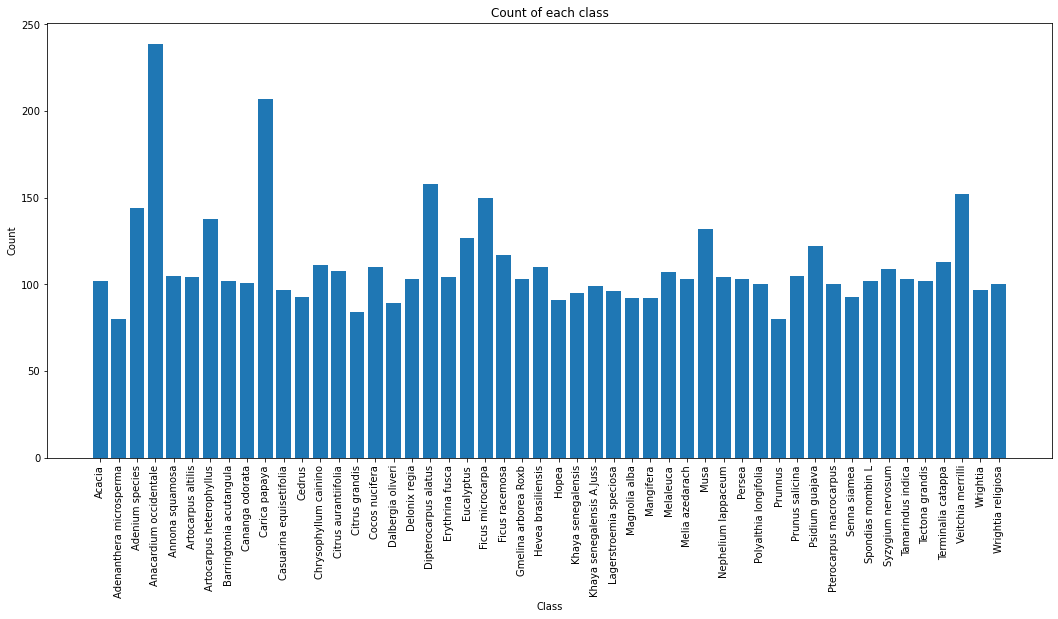

In [48]:
# visualize count of each class
classes = dataset.classes
class_count = [0] * len(classes)
for _, label in dataset:
    class_count[label] += 1
plt.figure(figsize=(18, 8))
plt.bar(classes, class_count)
plt.xticks(rotation=90)
plt.title('Count of each class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

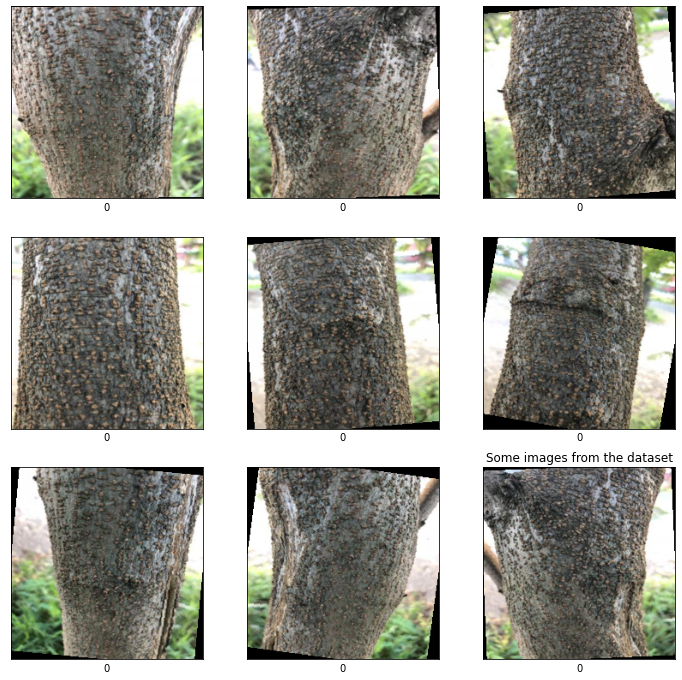

In [49]:
# plot some images to see what we are dealing with
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(torch.permute(dataset[i][0],(1, 2, 0)).numpy())
    plt.xlabel(dataset[i][1])
plt.title('Some images from the dataset')
plt.show()

### Split data 

- train 80%
- val 10%
- test 10%

In [50]:
#split data into train and test and validate
train_size = int(train_split * len(dataset))
val_size = int(val_split * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

### Load Pretrained Resnet50 model and apply transfer learning

In [51]:
# Load pretrained model
model = models.resnet50(weights=models. ResNet50_Weights.DEFAULT)
# model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
# print(model)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

# Replace last layer for transfer learning since we have 50 classes
model.fc = nn.Sequential(
                      nn.Linear(model.fc.in_features, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.3),
                      nn.Linear(256, num_classes),                   
                      nn.LogSoftmax(dim=1))

### Train Model to update the weights modified fc layer

- Tracked validation loss to early stop


In [ ]:
# Initialize model
model = model.to(device)

# Loss and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Train network
# do early stopping
best_val_loss = float('inf')
best_val_acc = 0
best_model = None

for epoch in range(num_epochs):
    counter = 0
    train_loss = 0
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to device
        data = data.to(device)
        targets = targets.to(device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)
        train_loss += loss.item()

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()


    # Display validation accuracy after every epoch
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        val_loss = 0
        for data, targets in val_loader:
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            val_loss += criterion(scores, targets)
            _, predictions = scores.max(1)
            n_correct += (predictions == targets).sum()
            n_samples += predictions.size(0)
        acc = 100.0 * n_correct/n_samples
        print(f'Epoch [{epoch}/{num_epochs}] train_Loss: {train_loss:.4f} Val_Loss: {val_loss:.4f} Validation accuracy: {acc:.2f}')

    # save best model
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_val_acc = acc
        best_model = model.state_dict()
        torch.save(best_model, 'model.ckpt')
    
    # early stopping
    if val_loss.item() > best_val_loss:
        if counter >=10:
            print('Early stopping')
            break
        else:
            counter += 1

### Load the saved model

In [ ]:
# load model
model = models.resnet50(weights=models. ResNet50_Weights.DEFAULT)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

# Replace last layer for transfer learning
model.fc = nn.Sequential(
                      nn.Linear(model.fc.in_features, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, num_classes),                   
                      nn.LogSoftmax(dim=1))

model.load_state_dict(torch.load('model.ckpt'))
model.to(device)
model.eval()

### Evaluate the model 

- Accuracy on train data: 98.52%
- Accuracy on test data: 96.06%

In [ ]:
# Check accuracy on training & test to see how our model generalizes
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        print(
            f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}'
        )

    model.train()

print('Checking accuracy on training set')
check_accuracy(train_loader, model)
print('\nChecking accuracy on validation set')
check_accuracy(test_loader, model)


Checking accuracy on training set
Got 4400 / 4462 with accuracy 98.61

Checking accuracy on validation set
Got 540 / 559 with accuracy 96.60
